In [1]:
using JuMP
using Ipopt
using LinearAlgebra
using MathOptInterface
const MOI = MathOptInterface
using SparseArrays
using BenchmarkTools
using Plots

In [2]:
function restoration_phase(xk, ρ)
#     println("Solving restoration problem")
    
    is_s_eq_0 = false
    
    nlrp = Model()
    set_silent(nlrp)
    @variable(nlrp, x[i=1:2])
    @NLobjective(nlrp, Min, (x[1] - 0.5)^2 + (x[2] - 0.5)^2)
    @NLconstraint(nlrp, c, 1 - x[1]^2 - x[2]^2 <= 0)
    pp = NLPEvaluator(nlrp)
    MOI.initialize(pp, [:Jac,:Grad,:Hess])

    while !is_s_eq_0
        
        #Constraint eval
        ggg=zeros(1)
        MOI.eval_constraint(pp,ggg,xk)

        #Jacobian eval
        JStru=MOI.jacobian_structure(pp)
        Ja=zeros(length(JStru))
        MOI.eval_constraint_jacobian(pp,Ja,xk)

        jr = Vector{Int64}(undef, length(Ja)); jc = Vector{Int64}(undef, length(Ja))
        for i in 1:length(JStru)
            jr[i] = JStru[i][1] |> Int
            jc[i] = JStru[i][2] |> Int
        end
        Jacobeval = sparse(jr, jc, Ja) 
        @assert size(Jacobeval, 1) == 1
                                        
        Jacobeval = vcat(Jacobeval...)
        
        restor_model = Model(Ipopt.Optimizer)
        set_silent(restor_model)
        @variable(restor_model, s >= 0)
        @variable(restor_model, d[i=1:2])

        @objective(restor_model, Min, s) 
        @constraint(restor_model, c1, ggg[1] + Jacobeval'*d - s <= 0)
        @constraint(restor_model, c2, d[1] <= ρ)
        @constraint(restor_model, c3, d[2] <= ρ) 
        @constraint(restor_model, c4, d[1] >= -ρ)
        @constraint(restor_model, c5, d[2] >= -ρ)
        optimize!(restor_model)

        proposed_xk = xk .+ value.(d)
        
        # merit function
        function m(x::Vector{<:Real}) 
            ce = zeros(1)
            MOI.eval_constraint(pp,ce,x)
            merit = norm(max(ce[1], 0))
            return merit
        end

        if abs(value(s)) < 1e-6
        elseif m(proposed_xk) < m(xk) 
#             println("restoration merit condition: success")
            xk = proposed_xk
            ρ += 1*ρ
        else
#             println("restoration merit condition: failed")
            ρ -= 0.5*ρ
        end
        
#         println("slack = $(value(s))")
        is_s_eq_0 = abs(value(s)) < 1e-6
    end
    
    return xk, ρ 
end

restoration_phase (generic function with 1 method)

In [3]:
function SLP_MF(x0::Vector{<:Real}, ρ, γ)
    # ρ and γ are parameters
    @assert γ>=0
    
    has_x_converged = false
    ctr = 0
    restor_ctr = 0
    xk = x0
    x_list = []
    
    nlmod = Model()
    set_silent(nlmod)
    @variable(nlmod, x[i=1:2])
    @NLobjective(nlmod, Min, (x[1] - 0.5)^2 + (x[2] - 0.5)^2)
    @NLconstraint(nlmod, c, 1 - x[1]^2 - x[2]^2 <= 0)
    p = NLPEvaluator(nlmod)
    MOI.initialize(p, [:Jac,:Grad,:Hess])
    

    while has_x_converged != [1, 1]
        ctr += 1
        
        #Objective eval
        objEv=MOI.eval_objective(p, xk)

        #Objective gradient
        df=zeros(length(xk))
        MOI.eval_objective_gradient(p,df,xk)
        #@show df;

        #Constraint eval
        gg=zeros(1)
        MOI.eval_constraint(p,gg,xk)
        #@show g;

        #Jacobian eval
        JStr=MOI.jacobian_structure(p)
        J=zeros(length(JStr))
        MOI.eval_constraint_jacobian(p,J,xk)
        #@show J;

        jr = Vector{Int64}(undef, length(J)); jc = Vector{Int64}(undef, length(J))
        for i in 1:length(JStr)
            jr[i] = JStr[i][1] |> Int
            jc[i] = JStr[i][2] |> Int
        end
        Jacobeval = sparse(jr, jc, J) 
        @assert size(Jacobeval, 1) == 1
                                        
        Jacobeval = vcat(Jacobeval...)

        model = Model(Ipopt.Optimizer)
        set_silent(model)
        @variable(model, d[i=1:2])
        @objective(model, Min, objEv + df'*d)
        @constraint(model, c1,  gg[1] + Jacobeval'*d <= 0)
        @constraint(model, c2, d[1] <= ρ)
        @constraint(model, c3, d[2] <= ρ) 
        @constraint(model, c4, d[1] >= -ρ)
        @constraint(model, c5, d[2] >= -ρ)
        
#         println("Iteration $ctr...")

        optimize!(model)
#         @show termination_status(model)
#         @show value.(d)
        
        # updating ρ
        proposed_xk = xk .+ value.(d)
        
        # merit function
        function m(x::Vector{<:Real}) 
            newobjev = MOI.eval_objective(p, x)
            ce = zeros(1)
            MOI.eval_constraint(p,ce,x)
            merit = newobjev + γ * norm(max(ce[1], 0))
            return merit
        end
        
#         println("m(xk) = $(m(xk))")
#         println("m(prop_xk) = $(m(proposed_xk))")
        
        if m(proposed_xk) < m(xk)
#             println("merit condition: success")
            xk = proposed_xk
            ρ += 1*ρ
        else
#             println("merit condition: failed")
            ρ -= 0.5*ρ
        end
        
#         println("d=$(value.(d))")
#         println("x$(ctr)=$(xk)")
#         println("new ρ: $ρ")
        
        x_list = push!(x_list, xk)
        
        #restoration phase:
        if termination_status(model) == MathOptInterface.LOCALLY_INFEASIBLE
            xk, ρ = restoration_phase(xk, ρ)
            restor_ctr += 1
        end
        
        #convergence test
        tol = 1e-6
        has_x_converged = abs.(value.(d)) .< tol
        
    end
#     println("no. restoration phases: $(restor_ctr)")
    return x_list
end

SLP_MF (generic function with 1 method)

In [4]:
x_list_1 = SLP_MF([-10., 20.], 4, 1)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



69-element Vector{Any}:
 [-5.99999996011933, 15.999999960064255]
 [2.000000118057776, 9.906249918264761]
 [2.000000118057776, 9.906249918264761]
 [2.000000118057776, 9.906249918264761]
 [-1.9999999211071326, 5.906249878397934]
 [-1.9999999211071326, 5.906249878397934]
 [2.0000001170204422, 4.0536540167432396]
 [2.0000001170204422, 4.0536540167432396]
 [2.0000001170204422, 4.0536540167432396]
 [1.1956263297797711, 2.0536539991875955]
 [1.1956263297797711, 2.0536539991875955]
 [1.1956263297797711, 2.0536539991875955]
 [0.9699249243775113, 1.0536539926877044]
 ⋮
 [0.7073182002143096, 0.7068956263528617]
 [0.7073182002143096, 0.7068956263528617]
 [0.7073182002143096, 0.7068956263528617]
 [0.7070817139096076, 0.7071319255799615]
 [0.7070817139096076, 0.7071319255799615]
 [0.7070817139096076, 0.7071319255799615]
 [0.7071586315460063, 0.7070549343792344]
 [0.7071586315460063, 0.7070549343792344]
 [0.7071586315460063, 0.7070549343792344]
 [0.70711956044374, 0.707094002836485]
 [0.7071195604437

In [5]:
x1 = []
x2 = []

for x in 1:length(x_list_1)
    x1 = push!(x1, x_list_1[x][1])
    x2 = push!(x2, x_list_1[x][2])
end
# display(x1)
# display(x2)

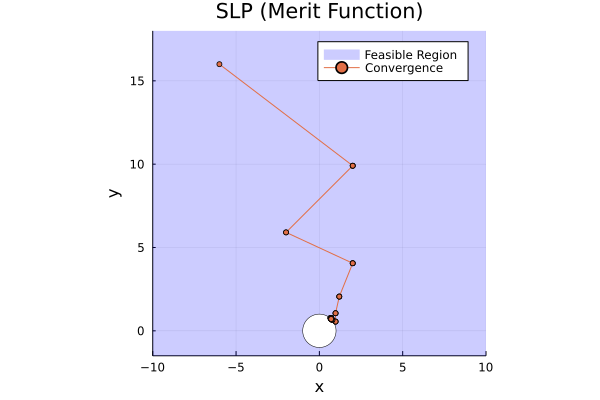

In [15]:
θ = 0:0.01:2π

x = cos.(θ); y = sin.(θ);

# slpmfplot = plot(x,y, seriestype=[:shape,],lw=0.5, c=:white, linecolor=:black, fillalpha=0.2, aspect_ratio=1, label="Feasible Region")
# plot!(slpmfplot, x1,x2, markershape = :circle, markersize = 3, xlims=(-10, 10), ylims=(-1.5,18), label="Convergence", xlabel = "x", ylabel = "y", title="SLP (Merit Function)")

rectangle(w, h, x, y) = Shape(x .+ [10,-10,-10,10], y .+ [-1.5,-1.5,18,18])

# plot(0:5,0:5)
slpmfplot = plot(rectangle(3,2,0,0), lw=0.5, c=:blue, linecolor=nothing, fillalpha=0.2,label="Feasible Region")
plot!(slpmfplot, x,y, seriestype=[:shape,],lw=0.5, c=:white, linecolor=:black, fillalpha=1, aspect_ratio=1, label="")
plot!(slpmfplot, x1,x2, markershape = :circle, markersize = 3, c=:2, xlims=(-10, 10), ylims=(-1.5,18), label="Convergence", xlabel = "x", ylabel = "y", title="SLP (Merit Function)")


In [16]:
savefig(slpmfplot, "slpmfplot_nc.pdf")

In [17]:
function SLP_F(x0::Vector{<:Real}, ρ)
    # ρ is the trust region parameter

    has_x_converged = false
    ctr = 0
    restor_ctr = 0
    xk = x0
    x_list =[]
    filt = []
    
    nlmod = Model()
    set_silent(nlmod)
    @variable(nlmod, x[i=1:2])
    @NLobjective(nlmod, Min, (x[1] - 0.5)^2 + (x[2] - 0.5)^2)
    @NLconstraint(nlmod, c, 1 - x[1]^2 - x[2]^2 <= 0)
    p = NLPEvaluator(nlmod)
    MOI.initialize(p, [:Jac,:Grad,:Hess])
    
    while has_x_converged != [1, 1]
        ctr += 1
        
        #Objective eval
        objEv=MOI.eval_objective(p, xk)

        #Objective gradient
        df=zeros(length(xk))
        MOI.eval_objective_gradient(p,df,xk)

        #Constraint eval
        gg=zeros(1)
        MOI.eval_constraint(p,gg,xk)

        #Jacobian eval
        JStr=MOI.jacobian_structure(p)
        J=zeros(length(JStr))
        MOI.eval_constraint_jacobian(p,J,xk)

        jr = Vector{Int64}(undef, length(J)); jc = Vector{Int64}(undef, length(J))
        for i in 1:length(JStr)
            jr[i] = JStr[i][1] |> Int
            jc[i] = JStr[i][2] |> Int
        end
        Jacobeval = sparse(jr, jc, J) 
        @assert size(Jacobeval, 1) == 1                              
        Jacobeval = vcat(Jacobeval...)
        
        model = Model(Ipopt.Optimizer)
        set_silent(model)
        @variable(model, d[i=1:2])

#         println("Iteration $ctr...")

        @objective(model, Min, objEv + df'*d) 
        @constraint(model, c1, gg[1] + Jacobeval'*d <= 0)
        @constraint(model, c2, d[1] <= ρ)
        @constraint(model, c3, d[2] <= ρ)
        @constraint(model, c4, d[1] >= -ρ)
        @constraint(model, c5, d[2] >= -ρ)

        optimize!(model)
        
        #functions for making the filter
        function fk(x::Vector{<:Real}) 
            newobjev = MOI.eval_objective(p, x)
            return newobjev
        end
        function hk(x::Vector{<:Real}) 
            ce = zeros(1)
            MOI.eval_constraint(p,ce,x)
            h = norm(max(ce[1], 0))
            return h
        end
        
        
        proposed_xk = xk .+ value.(d)
        better_obj = all(v -> fk(proposed_xk) < v[1], filt)
        better_constr = all(v -> hk(proposed_xk) < v[2], filt)
        
#         println("f(propxk) = $(fk(proposed_xk))")
#         println("f(xk) = $(fk(xk))")
        
        if better_obj || better_constr
#             println("filter: accept")
            xk = proposed_xk
            ρ += 1*ρ
            filt = push!(filt, (fk(xk), hk(xk)))
        else
#             println("filter: reject")
            ρ -= 0.5*ρ
            filt = push!(filt, (fk(proposed_xk), hk(proposed_xk)))
        end
        
        
#         println("d=$(value.(d))")
#         println("x$(ctr)=$xk")  
        x_list = push!(x_list, xk)
        
        #restoration phase:
        if termination_status(model) == MathOptInterface.LOCALLY_INFEASIBLE
            xk, ρ = restoration_phase(xk, ρ)
            restor_ctr += 1
        end
    
        #convergence test
        tol = 1e-6
        has_x_converged = abs.(value.(d)) .< tol
    end
#     println("no. restoration phases: $(restor_ctr)")
    return x_list
end


SLP_F (generic function with 1 method)

In [18]:
x_list_2 = SLP_F([-10., 20.], 4)

76-element Vector{Any}:
 [-5.99999996011933, 15.999999960064255]
 [2.000000118057776, 9.906249918264761]
 [2.000000118057776, 9.906249918264761]
 [2.000000118057776, 9.906249918264761]
 [-1.9999999211071326, 5.906249878397934]
 [-1.9999999211071326, 5.906249878397934]
 [2.0000001170204422, 4.0536540167432396]
 [2.0000001170204422, 4.0536540167432396]
 [2.0000001170204422, 4.0536540167432396]
 [1.1956263297797711, 2.0536539991875955]
 [1.1956263297797711, 2.0536539991875955]
 [1.1956263297797711, 2.0536539991875955]
 [0.9699249243775113, 1.0536539926877044]
 ⋮
 [0.7071586315460063, 0.7070549343792344]
 [0.7071586315460063, 0.7070549343792344]
 [0.70711956044374, 0.707094002836485]
 [0.7071154105952763, 0.7070981506344823]
 [0.7071154105952763, 0.7070981506344823]
 [0.707112580429735, 0.70710098084472]
 [0.707112580429735, 0.70710098084472]
 [0.7071106652186254, 0.7071028960758916]
 [0.7071106652186254, 0.7071028960758916]
 [0.7071093764036789, 0.7071041848997921]
 [0.7071093764036789, 0

In [19]:
x11 = []
x22 = []

for x in 1:length(x_list_2)
    x11 = push!(x11, x_list_2[x][1])
    x22 = push!(x22, x_list_2[x][2])
end

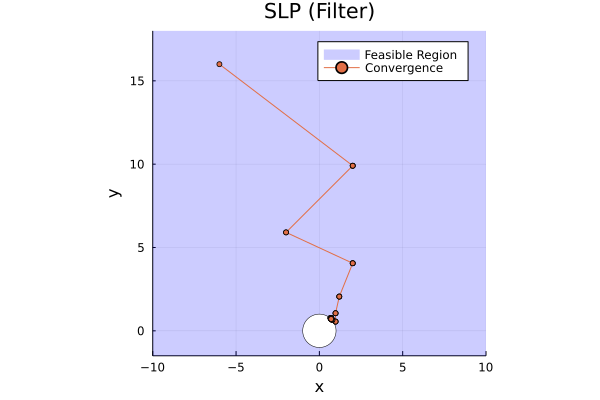

In [22]:
θ = 0:0.01:2π

x = cos.(θ); y = sin.(θ);

# slpfplot = plot(x,y, seriestype=[:shape,],lw=0.5, c=:blue, linecolor=:black, fillalpha=0.2, aspect_ratio=1, label="Feasible Region")
# plot!(slpfplot, x11,x22, markershape = :circle, markersize = 3, xlims=(-10, 10), ylims=(-1.5,18), label="Convergence", xlabel = "x", ylabel = "y", title="SLP (Filter)", legend=:topright)

rectangle(w, h, x, y) = Shape(x .+ [10,-10,-10,10], y .+ [-1.5,-1.5,18,18])

slpfplot = plot(rectangle(3,2,0,0), lw=0.5, c=:blue, linecolor=nothing, fillalpha=0.2,label="Feasible Region")
plot!(slpfplot, x,y, seriestype=[:shape,],lw=0.5, c=:white, linecolor=:black, fillalpha=1, aspect_ratio=1, label="")
plot!(slpfplot, x11,x22, markershape = :circle, markersize = 3, c=:2, xlims=(-10, 10), ylims=(-1.5,18), label="Convergence", xlabel = "x", ylabel = "y", title="SLP (Filter)", legend=:topright)

In [23]:
savefig(slpfplot, "slpfplot_nc.pdf")

In [24]:
function SQP_MF(x0::Vector{<:Real}, λ0::Vector{Float64}, ρ, γ)
    # λ, μ are initial lagrangian multipliers
    # ρ and γ are parameters

    has_x_converged = false
    ctr = 0
    restor_ctr = 0
    xk = x0
    λk = λ0
    x_list = []
    
    # hessian of the lagrangian model
    mhl = Model(Ipopt.Optimizer)
    @variable(mhl, x[i=1:2])
    @NLobjective(mhl, Min, (x[1] - 0.5)^2 + (x[2] - 0.5)^2)
    @NLconstraint(mhl, c, 1 - x[1]^2 - x[2]^2 <= 0)
    p = NLPEvaluator(mhl)
    MOI.initialize(p, [:Jac,:Grad,:Hess])
    
    
    while has_x_converged != [1, 1]
        ctr += 1
        
        #Objective eval
        objEv=MOI.eval_objective(p, xk)

        #Objective gradient
        df=zeros(length(xk))
        MOI.eval_objective_gradient(p,df,xk)

        #Constraint eval
        gg=zeros(1)
        MOI.eval_constraint(p,gg,xk)

        #Jacobian eval
        JStr=MOI.jacobian_structure(p)
        J=zeros(length(JStr))
        MOI.eval_constraint_jacobian(p,J,xk)

        jr = Vector{Int64}(undef, length(J)); jc = Vector{Int64}(undef, length(J))
        for i in 1:length(JStr)
            jr[i] = JStr[i][1] |> Int
            jc[i] = JStr[i][2] |> Int
        end
        Jacobeval = sparse(jr, jc, J) 
        @assert size(Jacobeval, 1) == 1                              
        Jacobeval = vcat(Jacobeval...)
        
        #Hessian-of-the-Lagrangian eval
        HStr=MOI.hessian_lagrangian_structure(p)
        H=zeros(length(HStr))
        MOI.eval_hessian_lagrangian(p,H,xk,1.0,repeat(λk,length(H))) # instead of repeat have lagrange multipliers
        
        hr = Vector{Int64}(undef, length(H)); hc = Vector{Int64}(undef, length(H))
        for i in 1:length(HStr)
            hr[i] = HStr[i][1] |> Int
            hc[i] = HStr[i][2] |> Int
        end
        
        HessLag = sparse(hr, hc, H)
        
        hessianobj(d) = 0.5*d'*(HessLag*d)
        
        model = Model(Ipopt.Optimizer)
        set_silent(model)
        @variable(model, d[i=1:2])
        
#         println("Iteration $ctr...")

        @objective(model, Min, objEv + df'*d + hessianobj(d)) 
        @constraint(model, c1, gg[1] + Jacobeval'*d <= 0)
        @constraint(model, c2, d[1] <= ρ)
        @constraint(model, c3, d[2] <= ρ)
        @constraint(model, c4, d[1] >= -ρ)
        @constraint(model, c5, d[2] >= -ρ)

        optimize!(model)
#         @show termination_status(model)
        
        # update λ
        λk[1] = shadow_price(c1)

        # merit function
        function m(x::Vector{<:Real}) 
            newobjev = MOI.eval_objective(p, x)
            ce = zeros(1)
            MOI.eval_constraint(p,ce,x)
            merit = newobjev + γ * norm(max(ce[1], 0))
            return merit
        end
        
        # updating ρ
        proposed_xk = xk .+ value.(d)
#         println("m(xk) = $(m(xk))")
#         println("m(prop_xk) = $(m(proposed_xk))")
        
        if m(proposed_xk) < m(xk)
#             println("merit condition: success")
            xk = proposed_xk
            ρ += 1*ρ
        else
#             println("merit condition: failed")
            ρ -= 0.5*ρ
        end
        
#         println("d=$(value.(d))")
#         println("x$ctr=$xk")
        x_list = push!(x_list, xk)
        #restoration phase:
        if termination_status(model) == MathOptInterface.LOCALLY_INFEASIBLE
            xk, ρ = restoration_phase(xk, ρ)
            restor_ctr += 1
        end
        
        
        #convergence test
        tol = 1e-6
        has_x_converged = abs.(value.(d)) .< tol
    end
#     println("no. restoration phases: $(restor_ctr)")
    return x_list
end

SQP_MF (generic function with 1 method)

In [25]:
x_list_3 = SQP_MF([-10., 20.], [1.], 4, 1)

43-element Vector{Any}:
 [-5.99999996011933, 15.999999960064255]
 [-2.4075341954082083, 8.253424557656272]
 [-0.819130551513271, 4.299492107214764]
 [0.036737658036389176, 2.3510675724668335]
 [0.39247042549128686, 1.3823574316936127]
 [0.5583607611399523, 0.9500672083976516]
 [0.6316161044346242, 0.7941833633012985]
 [0.6719385640402745, 0.7434376837804823]
 [0.6910597291758359, 0.7233300661744381]
 [0.6998162523357883, 0.7144319870689613]
 [0.7037994363145512, 0.7104212160957775]
 [0.7056074192636745, 0.7086075971179253]
 [0.7064272683813981, 0.707786591675741]
 ⋮
 [0.7070938037612814, 0.7071197578509063]
 [0.7070938037612814, 0.7071197578509063]
 [0.7070938037612814, 0.7071197578509063]
 [0.7070938037612814, 0.7071197578509063]
 [0.7071009011482017, 0.7071126604748541]
 [0.7071009011482017, 0.7071126604748541]
 [0.7071009011482017, 0.7071126604748541]
 [0.7071041168459892, 0.7071094447833335]
 [0.7071041168459892, 0.7071094447833335]
 [0.7071041168459892, 0.7071094447833335]
 [0.707

In [26]:
x111 = []
x222 = []

for x in 1:length(x_list_3)
    x111 = push!(x111, x_list_3[x][1])
    x222 = push!(x222, x_list_3[x][2])
end

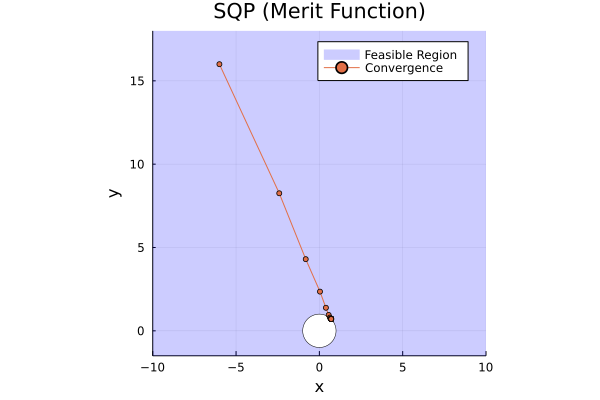

In [28]:
θ = 0:0.01:2π

x = cos.(θ); y = sin.(θ);

# sqpmfplot = plot(x,y, seriestype=[:shape,],lw=0.5, c=:blue, linecolor=:black, fillalpha=0.2, aspect_ratio=1, label="Feasible Region")
# plot!(sqpmfplot, x111,x222, markershape = :circle, markersize = 3, xlims=(-10,10), ylims=(-1.5,18), label="Convergence", xlabel = "x", ylabel = "y", title="SQP (Merit Function)", legend=:topright)

rectangle(w, h, x, y) = Shape(x .+ [10,-10,-10,10], y .+ [-1.5,-1.5,18,18])

sqpmfplot = plot(rectangle(3,2,0,0), lw=0.5, c=:blue, linecolor=nothing, fillalpha=0.2,label="Feasible Region")
plot!(sqpmfplot, x,y, seriestype=[:shape,],lw=0.5, c=:white, linecolor=:black, fillalpha=1, aspect_ratio=1, label="")
plot!(sqpmfplot, x111,x222, markershape = :circle, markersize = 3, c=:2, xlims=(-10, 10), ylims=(-1.5,18), label="Convergence", xlabel = "x", ylabel = "y", title="SQP (Merit Function)", legend=:topright)

In [29]:
savefig(sqpmfplot, "sqpmfplot_nc.pdf")

In [30]:
function SQP_F(x0::Vector{<:Real}, λ0::Vector{Float64}, ρ)
    # λ is initial lagrangian multiplier
    # ρ is the trust region parameter

    xk = x0
    λk = λ0
    has_x_converged = false
    ctr = 0
    restor_ctr = 0
    x_list = []
    
    filt = []
    
    # hessian of the lagrangian model
    mhl = Model(Ipopt.Optimizer)
    @variable(mhl, x[i=1:2])
    @NLobjective(mhl, Min, (x[1] - 0.5)^2 + (x[2] - 0.5)^2)
    @NLconstraint(mhl, c1, 1 - x[1]^2 - x[2]^2 <= 0)
    p = NLPEvaluator(mhl)
    MOI.initialize(p, [:Jac,:Grad,:Hess])
    
    
    while has_x_converged != [1, 1]
        ctr += 1
        
        #Objective eval
        objEv=MOI.eval_objective(p, xk)

        #Objective gradient
        df=zeros(length(xk))
        MOI.eval_objective_gradient(p,df,xk)

        #Constraint eval
        gg=zeros(1)
        MOI.eval_constraint(p,gg,xk)

        #Jacobian eval
        JStr=MOI.jacobian_structure(p)
        J=zeros(length(JStr))
        MOI.eval_constraint_jacobian(p,J,xk)

        jr = Vector{Int64}(undef, length(J)); jc = Vector{Int64}(undef, length(J))
        for i in 1:length(JStr)
            jr[i] = JStr[i][1] |> Int
            jc[i] = JStr[i][2] |> Int
        end
        Jacobeval = sparse(jr, jc, J) 
        @assert size(Jacobeval, 1) == 1                              
        Jacobeval = vcat(Jacobeval...)
        
        #Hessian-of-the-Lagrangian eval
        HStr=MOI.hessian_lagrangian_structure(p)
        H=zeros(length(HStr))
        MOI.eval_hessian_lagrangian(p,H,xk,1.0,repeat(λk,length(H))) 
        
        hr = Vector{Int64}(undef, length(H)); hc = Vector{Int64}(undef, length(H))
        for i in 1:length(HStr)
            hr[i] = HStr[i][1] |> Int
            hc[i] = HStr[i][2] |> Int
        end
        HessLag = sparse(hr, hc, H)
        
        hessianobj(d) = 0.5*d'*(HessLag*d)
        
        model = Model(Ipopt.Optimizer)
        set_silent(model)
        @variable(model, d[i=1:2])
        
#         println("Iteration $ctr...")

        @objective(model, Min, objEv + df'*d + hessianobj(d)) 
        @constraint(model, c1, gg[1] + Jacobeval'*d <= 0)
        @constraint(model, c2, d[1] <= ρ)
        @constraint(model, c3, d[2] <= ρ)
        @constraint(model, c4, d[1] >= -ρ)
        @constraint(model, c5, d[2] >= -ρ)

        optimize!(model)
        
        # update λ
        λk[1] = shadow_price(c1)

        #functions for making the filter
        function fk(x::Vector{<:Real}) 
            newobjev = MOI.eval_objective(p, x)
            return newobjev
        end
        function hk(x::Vector{<:Real}) 
            ce = zeros(1)
            MOI.eval_constraint(p,ce,x)
            h = norm(max(ce[1], 0))
            return h
        end
        
        # updating ρ
        proposed_xk = xk .+ value.(d)
        better_obj = all(v -> fk(proposed_xk) < v[1], filt)
        better_constr = all(v -> hk(proposed_xk) < v[2], filt)
        
        if better_obj || better_constr
#             println("filter: accept")
            xk = proposed_xk
            ρ += 1*ρ
            filter = push!(filt, (fk(xk), hk(xk)))
        else
#             println("filter: reject")
            ρ -= 0.5*ρ
            filter = push!(filt, (fk(proposed_xk), hk(proposed_xk)))
        end
        
#         println("f(propxk) = $(fk(proposed_xk))")
#         println("d=$(value.(d))")
#         println("x$ctr=$xk")
        x_list = push!(x_list, xk)
        
        #restoration phase:
        if termination_status(model) == MathOptInterface.LOCALLY_INFEASIBLE
            xk, ρ = restoration_phase(xk, ρ)
            restor_ctr += 1
        end
        
        #convergence test
        tol = 1e-6
        has_x_converged = abs.(value.(d)) .< tol
    end
#     println("no. restoration phases: $(restor_ctr)")
    return x_list
end

SQP_F (generic function with 1 method)

In [31]:
x_list_4 = SQP_F([-10., 20.], [1.], 4)

22-element Vector{Any}:
 [-5.99999996011933, 15.999999960064255]
 [-2.4075341954082083, 8.253424557656272]
 [-0.819130551513271, 4.299492107214764]
 [0.036737658036389176, 2.3510675724668335]
 [0.39247042549128686, 1.3823574316936127]
 [0.5583607611399523, 0.9500672083976516]
 [0.6316161044346242, 0.7941833633012985]
 [0.6719385640402745, 0.7434376837804823]
 [0.6910597291758359, 0.7233300661744381]
 [0.6998162523357883, 0.7144319870689613]
 [0.7037994363145512, 0.7104212160957775]
 [0.7056074192636745, 0.7086075971179253]
 [0.7064272683813981, 0.707786591675741]
 [0.7067988691474159, 0.7074147535843993]
 [0.7069672639926179, 0.7072463100215477]
 [0.7070435666638383, 0.7071699973494694]
 [0.707078139293151, 0.707135422740469]
 [0.7070938037612814, 0.7071197578509063]
 [0.7071009010995146, 0.7071126604261645]
 [0.7071041167485957, 0.7071094446859366]
 [0.7071055737196196, 0.7071079877112667]
 [0.7071062338471819, 0.7071073275829561]

In [33]:
x1111 = []
x2222 = []

for x in 1:length(x_list_4)
    x1111 = push!(x1111, x_list_4[x][1])
    x2222 = push!(x2222, x_list_4[x][2])
end

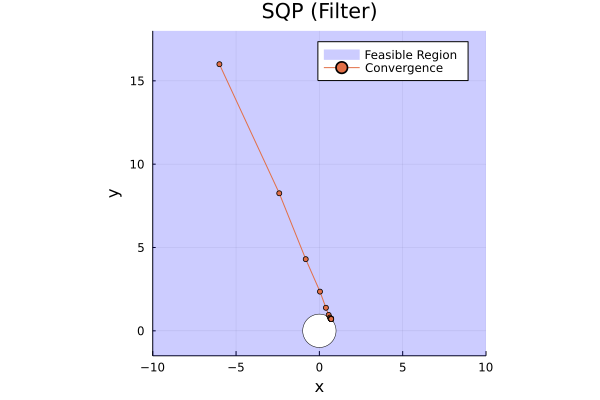

In [34]:
θ = 0:0.01:2π

x = cos.(θ); y = sin.(θ);

# sqpfplot = plot(x,y, seriestype=[:shape,],lw=0.5, c=:blue, linecolor=:black, fillalpha=0.2, aspect_ratio=1, label="Feasible Region")
# plot!(sqpfplot, x1111,x2222, markershape = :circle, markersize = 3, xlims=(-10,10), ylims=(-1.5,18), label="Convergence", xlabel = "x", ylabel = "y", title="SQP (Filter)", legend=:topright)

rectangle(w, h, x, y) = Shape(x .+ [10,-10,-10,10], y .+ [-1.5,-1.5,18,18])

sqpfplot = plot(rectangle(3,2,0,0), lw=0.5, c=:blue, linecolor=nothing, fillalpha=0.2,label="Feasible Region")
plot!(sqpfplot, x,y, seriestype=[:shape,],lw=0.5, c=:white, linecolor=:black, fillalpha=1, aspect_ratio=1, label="")
plot!(sqpfplot, x1111,x2222, markershape = :circle, markersize = 3, c=:2, xlims=(-10, 10), ylims=(-1.5,18), label="Convergence", xlabel = "x", ylabel = "y", title="SQP (Filter)", legend=:topright)

In [35]:
savefig(sqpfplot, "sqpfplot_nc.pdf")